# Reframing Bullpen Value: WAR, WPA, and the Leverage Gap

High-leverage relievers sit in a valuation gap between baseball's two primary value metrics. Using Fangraphs pitcher data from 2016–2025, this analysis shows that **WAR systematically undervalues** elite relievers while **WPA systematically overvalues** them — and the truth lies somewhere in between.

**The Core Tension**: WAR says high-leverage relievers are barely worth noticing. WPA says they're the most impactful pitchers in baseball. Neither is fully right. Every team generates a large number of high-leverage moments over a season, and elite relief skill reliably converts those moments into real wins — but raw WPA overstates the pitcher's individual contribution by conflating skill with opportunity.

## Data & Methodology

**Key Metrics**:
- **WAR** (Wins Above Replacement): Measures pitcher value via performance (ERA/FIP) × volume (IP). Isolates underlying skill but **ignores leverage**, treating all innings as equally important.
- **WPA** (Win Probability Added): Measures actual impact on win probability, fully incorporating timing and context. But it also absorbs **managerial usage patterns, sequencing luck, and situational noise** that the pitcher doesn't control.
- **pLI** (Average Leverage Index): Quantifies the average importance of the game situations in which a pitcher is used. Crucially, leverage is determined by game flow and managerial deployment — not by the reliever himself.

**WAR Variant — fWAR**: All WAR values are **fWAR**, built on FIP (strikeouts, walks, HBP, home runs) rather than runs allowed — a better measure of repeatable skill.

**Pitcher Classification**: **SP**: GS ≥ 5 and IP ≥ 20. **RP**: G ≥ 5 and GS < 3. Pitchers meeting neither definition are excluded.

**Data**: All data from [Fangraphs](https://www.fangraphs.com/) via [pybaseball](https://github.com/jldbc/pybaseball), 2016–2025, minimum 5 IP per season.

## 1. Load & Classify Pitcher Data

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.express as px
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Georgia', 'Cambria']

# --- Data Loading ---
from pybaseball import pitching_stats

START_YEAR = 2016
END_YEAR = 2025
QUAL = 5
CSV_PATH = f'fangraphs_pitchers_{START_YEAR}_{END_YEAR}_IP{QUAL}.csv'

if os.path.exists(CSV_PATH):
    print(f"Loading cached data from {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print("Fetching pitcher data from Fangraphs...")
    df = pitching_stats(start_season=START_YEAR, end_season=END_YEAR, qual=QUAL)
    df.to_csv(CSV_PATH, index=False)
    print(f"Saved data to {CSV_PATH}")

# Rename columns
rename_map = {
    'Name': 'Player', 'K%': 'Strikeout_Rate', 'BB%': 'Walk_Rate',
    'pLI': 'LI', 'WPA/LI': 'WPA_LI', 'SO': 'Strikeouts', 'BB': 'Walks',
    'G': 'Games', 'GS': 'Games_Started', 'FIP': 'FIP', 'ERA': 'ERA',
    'WAR': 'WAR', 'WPA': 'WPA', 'WHIP': 'WHIP'
}
df = df.rename(columns=rename_map)

# Classify: SP (>=5 GS, >=20 IP) vs RP (>=5 G, <3 GS)
def classify_pitcher(row):
    if row.get('Games_Started', 0) >= 5 and row.get('IP', 0) >= 20:
        return 'SP'
    elif row.get('Games', 0) >= 5 and row.get('Games_Started', 0) < 3:
        return 'RP'
    return 'Other'

df['Pitcher_Type'] = df.apply(classify_pitcher, axis=1)
df = df[df['Pitcher_Type'].isin(['SP', 'RP'])].reset_index(drop=True)

for col in ['IP', 'LI', 'FIP', 'ERA', 'WAR', 'WPA', 'WHIP', 'Games', 'Games_Started']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Loaded {len(df)} pitcher-seasons ({START_YEAR}\u2013{END_YEAR})")
print(f"  SP seasons: {(df['Pitcher_Type'] == 'SP').sum()}")
print(f"  RP seasons: {(df['Pitcher_Type'] == 'RP').sum()}")

Loading cached data from fangraphs_pitchers_2016_2025_IP5.csv
Loaded 6314 pitcher-seasons (2016–2025)
  SP seasons: 2337
  RP seasons: 3977


## 2. Aggregate & Identify High-Leverage Relievers

We aggregate each pitcher's career totals across all seasons, then use **k-means clustering (k=3)** on average pLI to separate relievers into three tiers: High, Medium, and Low leverage. The scatter plot below shows the resulting clusters — each dot is one reliever's aggregated career, positioned by total innings pitched and average pLI.

In [7]:
# Aggregate by pitcher
agg_dict = {
    'IP': 'sum', 'WPA': 'sum', 'WAR': 'sum', 'Games': 'sum', 'Games_Started': 'sum',
    'ERA': 'mean', 'FIP': 'mean', 'WHIP': 'mean', 'LI': 'mean',
    'Pitcher_Type': 'first', 'Season': 'count'
}
df_agg = df.groupby('Player').agg(agg_dict).reset_index()
df_agg.rename(columns={'Season': 'Seasons'}, inplace=True)

# Cluster relievers by leverage
rp_df = df_agg[df_agg['Pitcher_Type'] == 'RP'].copy().dropna(subset=['IP', 'LI'])
kmeans = KMeans(n_clusters=3, random_state=42)
rp_df['Leverage_Cluster'] = kmeans.fit_predict(rp_df[['LI']].values)

cluster_means = rp_df.groupby('Leverage_Cluster')['LI'].mean()
high_leverage_cluster = cluster_means.idxmax()
rp_df['High_Leverage'] = rp_df['Leverage_Cluster'] == high_leverage_cluster

# Build comparison groups
sp_df = df_agg[df_agg['Pitcher_Type'] == 'SP'].copy()
high_lev_rp_df = rp_df[rp_df['High_Leverage']].copy()
high_lev_rp_df['Pitcher_Type'] = 'RP (High Lev)'

comparison_df = pd.concat([sp_df, high_lev_rp_df], ignore_index=True)
comparison_df = comparison_df.dropna(subset=['ERA', 'IP', 'LI'])

print(f"\nAggregated pitchers: {len(df_agg)} total")
print(f"  SPs: {len(sp_df)}")
print(f"  All RPs: {len(rp_df)}")
print(f"  High-Leverage RPs: {len(high_lev_rp_df)} (avg pLI: {high_lev_rp_df['LI'].mean():.2f})")


Aggregated pitchers: 1860 total
  SPs: 665
  All RPs: 1195
  High-Leverage RPs: 272 (avg pLI: 1.34)


## The SP/RP Divide: Innings and pLI

Before clustering relievers by leverage, it's worth seeing just how differently SPs and RPs are deployed. The violin plots below show the distributions of **Innings Pitched** and **pLI** across all pitcher-seasons — not aggregated, but each individual season as its own data point.

**Volume vs. Leverage**: Starting pitchers dominate the workload side of the equation — their IP distribution stretches far above anything relievers produce, reflecting the fundamental design of the role. A typical SP season covers three to four times the innings of a typical RP season, which is precisely why WAR favors them so heavily.

**Leverage concentration**: While starting pitchers cluster tightly around a league-average pLI (~1.0), relievers show enormous variance. A substantial group of relievers consistently operate well above that baseline — these are the high-leverage arms deployed in the highest-stakes situations.

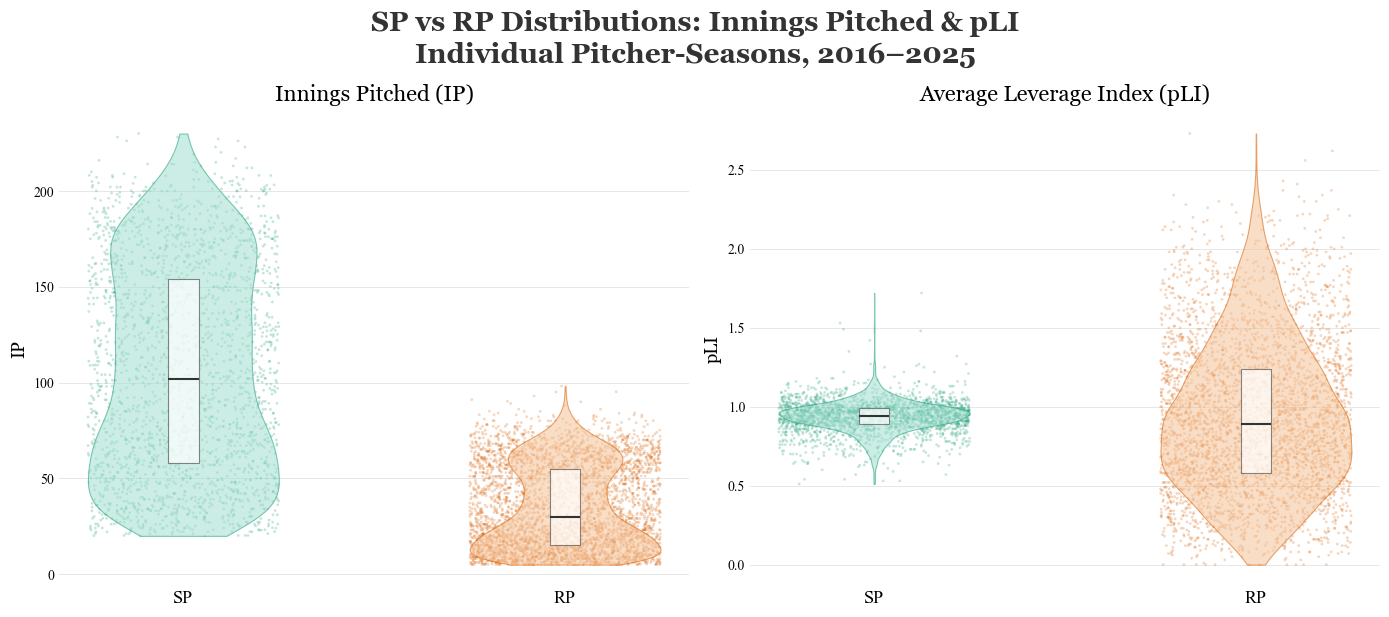

SP seasons: 2337, RP seasons: 3977
SP median IP: 102.0, RP median IP: 30.0
SP median pLI: 0.94, RP median pLI: 0.89


In [ ]:
# Violin + jittered strip plots: IP and pLI distributions — SPs vs RPs (individual seasons)

violin_df = df[['Pitcher_Type', 'IP', 'LI']].dropna().copy()

sp_data = violin_df[violin_df['Pitcher_Type'] == 'SP']
rp_data = violin_df[violin_df['Pitcher_Type'] == 'RP']

fig_v, (ax_ip, ax_li) = plt.subplots(1, 2, figsize=(14, 6))

sp_color, rp_color = '#1B9E77', '#D95F02'
sp_pale, rp_pale = '#A3DFD0', '#F5C49A'

def draw_violin_with_strip(ax, datasets, positions, colors, pale_colors, jitter_width=0.25):
    """Violin (pale fill) + jittered data points + narrow box (Q1–Q3, median line)."""
    rng = np.random.default_rng(42)

    # Draw violin shapes
    parts = ax.violinplot(datasets, positions=positions, showmeans=False, showmedians=False, showextrema=False)
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(pale_colors[i])
        pc.set_edgecolor(colors[i])
        pc.set_alpha(0.55)
        pc.set_linewidth(0.8)
        pc.set_zorder(3)

    # Scatter jittered points
    for i, (data, pos) in enumerate(zip(datasets, positions)):
        jitter = rng.uniform(-jitter_width, jitter_width, size=len(data))
        ax.scatter(pos + jitter, data, s=4, alpha=0.25, color=colors[i],
                   edgecolors='none', zorder=1, rasterized=True)

    # Narrow box + median
    box_width = 0.08
    for i, (data, pos) in enumerate(zip(datasets, positions)):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        median = np.median(data)
        ax.bar(pos, q3 - q1, bottom=q1, width=box_width,
               color='white', alpha=0.7, edgecolor='#555', linewidth=0.8, zorder=5)
        ax.hlines(median, pos - box_width / 2, pos + box_width / 2,
                  color='#333', linewidth=1.5, zorder=6)

# IP violin + strip
draw_violin_with_strip(ax_ip,
    [sp_data['IP'].values, rp_data['IP'].values],
    [1, 2], [sp_color, rp_color], [sp_pale, rp_pale])
ax_ip.set_xticks([1, 2])
ax_ip.set_xticklabels(['SP', 'RP'], fontsize=13)
ax_ip.set_ylabel('IP', fontsize=13, fontname='Georgia')
ax_ip.set_title('Innings Pitched (IP)', fontsize=16, fontname='Georgia', pad=8)
for spine in ax_ip.spines.values(): spine.set_visible(False)
ax_ip.tick_params(length=0)
ax_ip.yaxis.grid(True, color='#ddd', linewidth=0.5)
ax_ip.set_axisbelow(True)

# pLI violin + strip
draw_violin_with_strip(ax_li,
    [sp_data['LI'].values, rp_data['LI'].values],
    [1, 2], [sp_color, rp_color], [sp_pale, rp_pale])
ax_li.set_xticks([1, 2])
ax_li.set_xticklabels(['SP', 'RP'], fontsize=13)
ax_li.set_ylabel('pLI', fontsize=13, fontname='Georgia')
ax_li.set_title('Average Leverage Index (pLI)', fontsize=16, fontname='Georgia', pad=8)
for spine in ax_li.spines.values(): spine.set_visible(False)
ax_li.tick_params(length=0)
ax_li.yaxis.grid(True, color='#ddd', linewidth=0.5)
ax_li.set_axisbelow(True)

fig_v.suptitle(f'SP vs RP Distributions: Innings Pitched & pLI\n{START_YEAR}\u2013{END_YEAR} Individual Pitcher-Seasons',
               fontsize=17, fontweight='normal', fontname='Georgia', color='#444', y=1.02)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

print(f"SP seasons: {(violin_df['Pitcher_Type']=='SP').sum()}, RP seasons: {(violin_df['Pitcher_Type']=='RP').sum()}")
print(f"SP median IP: {sp_data['IP'].median():.1f}, RP median IP: {rp_data['IP'].median():.1f}")
print(f"SP median pLI: {sp_data['LI'].median():.2f}, RP median pLI: {rp_data['LI'].median():.2f}")

In [ ]:
# Visualize the 3 leverage clusters
cluster_li = rp_df.groupby('Leverage_Cluster')['LI'].mean().sort_values()
cluster_order = list(cluster_li.index)
cluster_labels = {cluster_order[0]: 'Low Leverage', cluster_order[1]: 'Medium Leverage', cluster_order[2]: 'High Leverage'}
cluster_colors = {cluster_order[0]: '#66A61E', cluster_order[1]: '#7570B3', cluster_order[2]: '#E7298A'}

# Round all hover columns for clean display
rp_df['ERA'] = rp_df['ERA'].round(2)
rp_df['WAR'] = rp_df['WAR'].round(2)
rp_df['LI'] = rp_df['LI'].round(2)
rp_df['IP'] = rp_df['IP'].round(1)

fig_cl = px.scatter(
    rp_df,
    x='IP', y='LI',
    color=rp_df['Leverage_Cluster'].map(cluster_labels),
    color_discrete_map={'Low Leverage': '#66A61E', 'Medium Leverage': '#7570B3', 'High Leverage': '#E7298A'},
    hover_data=['Player', 'ERA', 'WAR', 'LI', 'IP', 'Seasons'],
    labels={'IP': 'Innings Pitched (IP)', 'LI': 'Average Leverage Index (pLI)', 'color': 'Cluster'},
    title=f'K-Means Clustering of Relievers by pLI<br><sup>k = 3, {START_YEAR}\u2013{END_YEAR}</sup>'
)
fig_cl.update_traces(marker=dict(size=8, opacity=0.4))
fig_cl.update_layout(
    font_family='Georgia, Times New Roman, serif',
    height=550, width=900,
    legend_title_text='Leverage Tier',
    hoverlabel=dict(font_family='Georgia, Times New Roman, serif'),
    title_x=0.5,
    title_font_size=20,
)
_hover_bg_cl = {'Low Leverage': '#E8F5E0', 'Medium Leverage': '#ECEAF5', 'High Leverage': '#FCE4F0'}
fig_cl.for_each_trace(lambda t: t.update(
    hoverlabel=dict(bgcolor=_hover_bg_cl.get(t.name, '#fff'), font_color='#333'),
    hovertemplate=t.hovertemplate.replace('=', ' = ') if t.hovertemplate else t.hovertemplate
))
fig_cl.show()

for label, cluster_id in [(l, c) for c, l in cluster_labels.items()]:
    n = (rp_df['Leverage_Cluster'] == cluster_id).sum()
    avg_li = rp_df[rp_df['Leverage_Cluster'] == cluster_id]['LI'].mean()
    print(f"  {label}: {n} pitchers (avg pLI: {avg_li:.2f})")

  Low Leverage: 317 pitchers (avg pLI: 0.36)
  Medium Leverage: 606 pitchers (avg pLI: 0.80)
  High Leverage: 272 pitchers (avg pLI: 1.34)


## 3. The Divergence: SPs vs High-Leverage RPs

The charts below reveal the valuation gap in stark terms. By WPA, high-leverage relievers outproduce all starting pitchers combined. By WAR, they're worth a fraction. Neither extreme reflects reality — WAR ignores that these innings matter more, while WPA inflates them with sequencing and managerial context the pitcher doesn't control. The true value of high-leverage relievers is **higher than WAR suggests, but substantially lower than raw WPA implies**.

Consider the asymmetry: a starter throwing six strong innings in a comfortable lead may shift win probability by only a few percentage points. A reliever striking out two batters with the tying run on third in the eighth inning can swing win probability by 30–40% in two minutes. Both performances require real skill — but WPA rewards the reliever's two minutes far more than the starter's six innings, not because the reliever is better, but because the *situation* carried more weight.

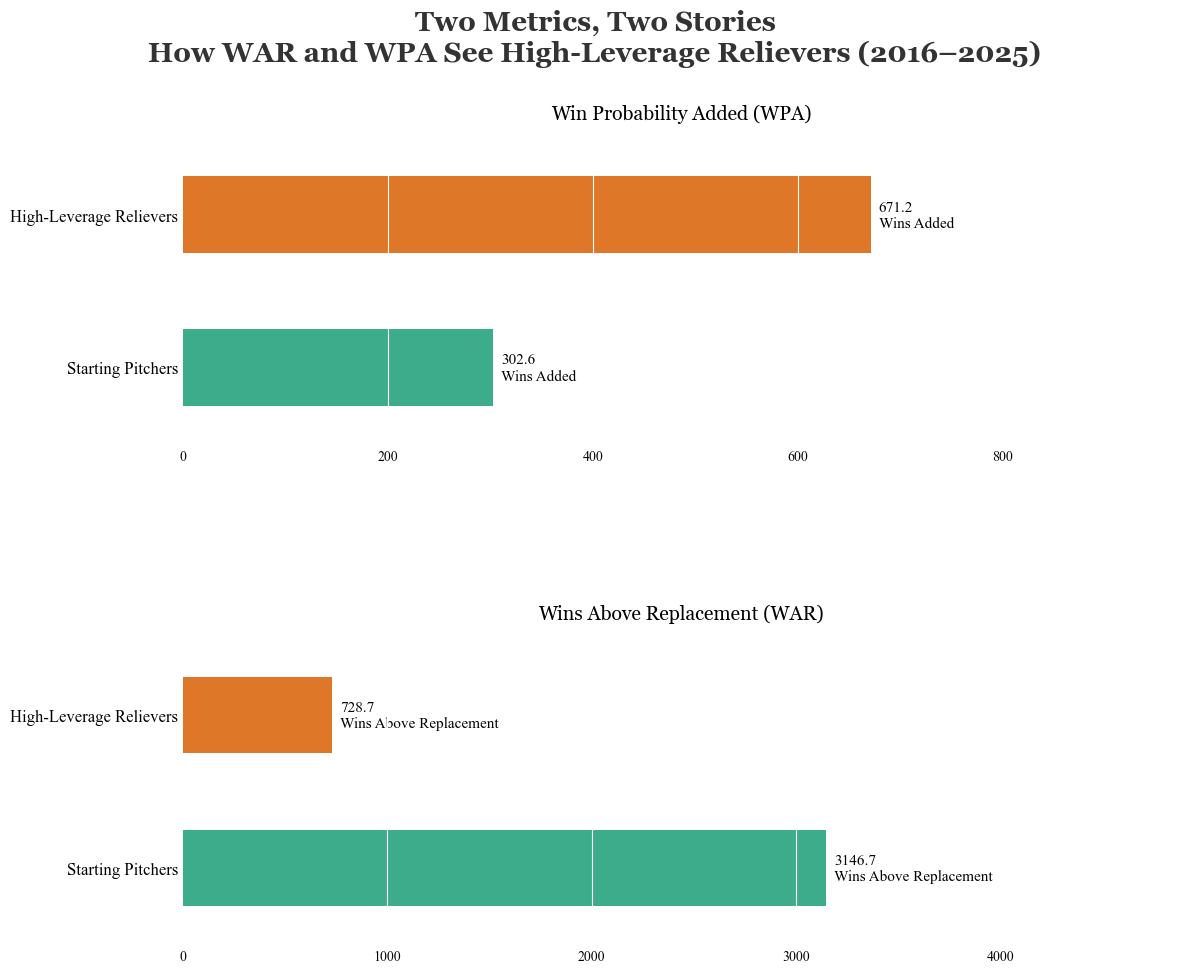

In [10]:
# WPA & WAR Comparison: SPs vs High-Leverage RPs
comparison_wpa = comparison_df.dropna(subset=['WPA'])
comparison_war = comparison_df.dropna(subset=['WAR'])

sp_total_wpa = comparison_wpa[comparison_wpa['Pitcher_Type'] == 'SP']['WPA'].sum()
rp_total_wpa = comparison_wpa[comparison_wpa['Pitcher_Type'] == 'RP (High Lev)']['WPA'].sum()
sp_total_war = comparison_war[comparison_war['Pitcher_Type'] == 'SP']['WAR'].sum()
rp_total_war = comparison_war[comparison_war['Pitcher_Type'] == 'RP (High Lev)']['WAR'].sum()

fig, axes = plt.subplots(2, 1, figsize=(12, 9.5))
categories = ['Starting Pitchers', 'High-Leverage Relievers']
colors = ['#1B9E77', '#D95F02']
bar_h = 0.35
y_pos = [0, bar_h * 2]

fig.suptitle(f'Two Metrics, Two Stories\nHow WAR and WPA See High-Leverage Relievers ({START_YEAR}\u2013{END_YEAR})',
             fontsize=20, fontweight='bold', fontname='Georgia', color='#333333', y=1.02)

def draw_white_gridlines(ax):
    """Draw white gridlines on top of bars using axvline at tick positions."""
    ticks = ax.xaxis.get_major_locator().tick_values(*ax.get_xlim())
    for t in ticks:
        if t > 0:
            ax.axvline(t, color='white', linewidth=0.8, zorder=10)

# WPA subplot
ax1 = axes[0]
wpa_values = [sp_total_wpa, rp_total_wpa]
bars1 = ax1.barh(y_pos, wpa_values, color=colors, alpha=0.85, height=bar_h, zorder=2)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(categories)
for bar, val in zip(bars1, wpa_values):
    ax1.text(bar.get_width() + 8, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}\nWins Added', va='center', ha='left', fontsize=11, fontweight='normal', fontname='serif', linespacing=1.2)
ax1.set_title('Win Probability Added (WPA)', fontsize=14, fontweight='normal', fontname='Georgia', pad=2)
ax1.xaxis.set_major_locator(mticker.AutoLocator())
ax1.yaxis.grid(False)
ax1.xaxis.grid(False)
ax1.tick_params(axis='x', length=0); ax1.tick_params(axis='y', length=0, labelsize=12)
for spine in ax1.spines.values(): spine.set_visible(False)
ax1.set_xlim(0, max(wpa_values) * 1.45)
ax1.set_ylim(-bar_h, y_pos[-1] + bar_h * 1.2)
draw_white_gridlines(ax1)

# WAR subplot
ax2 = axes[1]
war_values = [sp_total_war, rp_total_war]
bars2 = ax2.barh(y_pos, war_values, color=colors, alpha=0.85, height=bar_h, zorder=2)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(categories)
for bar, val in zip(bars2, war_values):
    ax2.text(bar.get_width() + 40, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}\nWins Above Replacement', va='center', ha='left', fontsize=11, fontweight='normal', fontname='serif', linespacing=1.2)
ax2.set_title('Wins Above Replacement (WAR)', fontsize=14, fontweight='normal', fontname='Georgia', pad=2)
ax2.xaxis.set_major_locator(mticker.AutoLocator())
ax2.yaxis.grid(False)
ax2.xaxis.grid(False)
ax2.tick_params(axis='x', length=0); ax2.tick_params(axis='y', length=0, labelsize=12)
for spine in ax2.spines.values(): spine.set_visible(False)
ax2.set_xlim(0, max(war_values) * 1.55)
ax2.set_ylim(-bar_h, y_pos[-1] + bar_h * 1.2)
draw_white_gridlines(ax2)

plt.tight_layout(h_pad=10)
plt.subplots_adjust(top=0.90)
plt.show()

wpa_ratio = (rp_total_wpa / sp_total_wpa) * 100
war_ratio = (rp_total_war / sp_total_war) * 100

## 4. Individual Season Scatter: WPA vs WAR

Each dot is a single pitcher-season. SPs spread horizontally (high WAR, moderate WPA) — their volume drives skill-based value but dilutes game-context impact. High-leverage RPs spread vertically (low WAR, wide WPA range) — their value is concentrated in high-stakes moments but inflated by sequencing and managerial deployment. The gap between the two clusters is the valuation no-man's-land where neither metric tells the full story.

In [11]:
# Interactive Scatter: WPA vs WAR — Individual Seasons (SPs vs High-Leverage RPs)
hl_rp_names = high_lev_rp_df['Player'].unique()

scatter_df = df[['Player', 'Pitcher_Type', 'Season', 'WAR', 'WPA', 'ERA', 'IP', 'LI']].dropna(subset=['WAR', 'WPA']).copy()
scatter_df = scatter_df[
    (scatter_df['Pitcher_Type'] == 'SP') | 
    ((scatter_df['Pitcher_Type'] == 'RP') & (scatter_df['Player'].isin(hl_rp_names)))
].copy()
scatter_df['Pitcher_Type'] = scatter_df['Pitcher_Type'].replace({'RP': 'RP (High Lev)'})

for col in ['WAR', 'WPA', 'ERA', 'IP', 'LI']:
    scatter_df[col] = scatter_df[col].round(2)

fig4 = px.scatter(
    scatter_df, x='WAR', y='WPA', color='Pitcher_Type',
    hover_data=['Player', 'Season', 'ERA', 'IP', 'LI', 'WAR', 'WPA'],
    labels={'WAR': 'Wins Above Replacement (WAR)', 'WPA': 'Win Probability Added (WPA)', 'LI': 'pLI'},
    title=f'WPA vs WAR: Starting Pitchers vs High-Leverage Relievers<br><sup>Individual Pitcher-Seasons, {START_YEAR}\u2013{END_YEAR}</sup>',
    color_discrete_map={'SP': '#1B9E77', 'RP (High Lev)': '#D95F02'}
)
fig4.update_traces(marker=dict(size=4, opacity=0.5))
fig4.update_layout(
    font_family='Georgia, Times New Roman, serif',
    height=650, width=950,
    hoverlabel=dict(font_family='Georgia, Times New Roman, serif'),
    xaxis_title_font_family='Georgia, Times New Roman, serif',
    yaxis_title_font_family='Georgia, Times New Roman, serif',
    title_x=0.5,
    title_font_size=20,
)
_hover_bg4 = {'SP': '#D4F0E7', 'RP (High Lev)': '#FDEBD0'}
fig4.for_each_trace(lambda t: t.update(
    hoverlabel=dict(bgcolor=_hover_bg4.get(t.name, '#fff'), font_color='#333'),
    hovertemplate=t.hovertemplate.replace('=', ' = ') if t.hovertemplate else t.hovertemplate
))
fig4.show()

### Top 25 Pitchers by Aggregate WPA

A single leaderboard combining SPs and high-leverage RPs, sorted by total WPA. The number of relievers that appear on this list — competing directly with aces who threw five times as many innings — speaks for itself.

In [ ]:
# Top 25 pitchers by aggregate WPA — SPs and High-Leverage RPs combined
cols = ['Player', 'WPA', 'WAR', 'IP', 'LI', 'Seasons', 'Pitcher_Type']

combined = pd.concat([
    sp_df[cols].assign(Role='SP'),
    high_lev_rp_df[cols].assign(Role='RP')
])
top25 = combined.nlargest(25, 'WPA').copy()
top25['WPA'] = top25['WPA'].round(1)
top25['WAR'] = top25['WAR'].round(1)
top25['IP']  = top25['IP'].round(1)
top25['LI']  = top25['LI'].round(2)
top25 = top25.reset_index(drop=True)
top25.index = top25.index + 1
top25 = top25.rename(columns={'LI': 'pLI'})[['Player', 'Role', 'WPA', 'WAR', 'IP', 'pLI', 'Seasons']]

# Highlight RP rows with subtle orange background
def highlight_rp(row):
    if row['Role'] == 'RP':
        return ['background-color: #FFF3E6'] * len(row)
    return [''] * len(row)

print(f"Top 25 Pitchers by Aggregate WPA ({START_YEAR}\u2013{END_YEAR})")
display(top25.style.apply(highlight_rp, axis=1))

## Conclusion

High-leverage relievers sit in a valuation gap because WAR and WPA measure fundamentally different things:

- **WAR** is designed to credit total volume of performance and isolate underlying skill. This leads it to systematically **undervalue** relievers by treating all innings as equally important and ignoring leverage.

- **WPA** measures who actually swings game outcomes, fully incorporating timing and context. This causes it to systematically **overvalue** relievers by absorbing managerial usage, sequencing, and luck.

Any serious evaluation of pitcher value must grapple with this gap. WAR is not wrong, and WPA is not wrong — but used alone, each tells an incomplete and misleading story.

Starters and offenses generate win probability; high-leverage relievers resolve it. By controlling the final allocation of wins, elite relievers occupy a structurally distinct role that makes their true value meaningfully larger than WAR suggests, even if the exact magnitude remains debatable. Leverage itself is not controlled by relievers — it is determined by game flow and managerial deployment — yet every team generates a large number of high-leverage moments over a season, meaning elite relief skill reliably translates into real wins.